# Amazon Bedrock boto3 Prerequisites

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

---

In this demo notebook, we demonstrate how to use the [`boto3` Python SDK](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to work with [Amazon Bedrock](https://aws.amazon.com/bedrock/) Foundation Models.

---

## Prerequisites

Run the cells in this section to install the packages needed by the notebooks in this workshop. ⚠️ You will see pip dependency errors, you can safely ignore these errors. ⚠️

IGNORE ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

In [2]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"


  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached docutils-0.16-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached rsa-4.7.2-py3-none-any.whl.metadata (3.6 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached pyasn1-0.6.0-py2.py3-none-any.whl.metadata (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 1.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 42.0 MB/s eta 0:00:00:00:0100:01
Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
Using cached docutils-0.16-py2.py3-none-any.whl (548 kB)
Using cached jmespath-1.0.1-py3-none-an

---

## Create the boto3 client

Interaction with the Bedrock API is done via the AWS SDK for Python: [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

#### Use different clients
The boto3 provides different clients for Amazon Bedrock to perform different actions. The actions for [`InvokeModel`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModel.html) and [`InvokeModelWithResponseStream`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModelWithResponseStream.html) are supported by Amazon Bedrock Runtime where as other operations, such as [ListFoundationModels](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_ListFoundationModels.html), are handled via [Amazon Bedrock client](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_Operations_Amazon_Bedrock.html).


#### Use the default credential chain

If you are running this notebook from [Amazon Sagemaker Studio](https://aws.amazon.com/sagemaker/studio/) and your Sagemaker Studio [execution role](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) has permissions to access Bedrock you can just run the cells below as-is. This is also the case if you are running these notebooks from a computer whose default AWS credentials have access to Bedrock.



In [3]:
import json
import os
import sys

import boto3

boto3_bedrock = boto3.client('bedrock')

#### Validate the connection

We can check the client works by trying out the `list_foundation_models()` method, which will tell us all the models available for us to use 

In [4]:
[models['modelId'] for models in boto3_bedrock.list_foundation_models()['modelSummaries']]


['amazon.titan-tg1-large',
 'amazon.titan-image-generator-v1:0',
 'amazon.titan-image-generator-v1',
 'amazon.titan-text-premier-v1:0',
 'amazon.titan-embed-g1-text-02',
 'amazon.titan-text-lite-v1:0:4k',
 'amazon.titan-text-lite-v1',
 'amazon.titan-text-express-v1:0:8k',
 'amazon.titan-text-express-v1',
 'amazon.titan-embed-text-v1:2:8k',
 'amazon.titan-embed-text-v1',
 'amazon.titan-embed-text-v2:0:8k',
 'amazon.titan-embed-text-v2:0',
 'amazon.titan-embed-image-v1:0',
 'amazon.titan-embed-image-v1',
 'stability.stable-diffusion-xl-v1:0',
 'stability.stable-diffusion-xl-v1',
 'ai21.j2-grande-instruct',
 'ai21.j2-jumbo-instruct',
 'ai21.j2-mid',
 'ai21.j2-mid-v1',
 'ai21.j2-ultra',
 'ai21.j2-ultra-v1:0:8k',
 'ai21.j2-ultra-v1',
 'ai21.jamba-instruct-v1:0',
 'anthropic.claude-instant-v1:2:100k',
 'anthropic.claude-instant-v1',
 'anthropic.claude-v2:0:18k',
 'anthropic.claude-v2:0:100k',
 'anthropic.claude-v2:1:18k',
 'anthropic.claude-v2:1:200k',
 'anthropic.claude-v2:1',
 'anthropic.c

In [5]:
print(f"Total number of Foundation Models Available: {len([models['modelId'] for models in boto3_bedrock.list_foundation_models()['modelSummaries']])}")

Total number of Foundation Models Available: 64


---

## `InvokeModel` body and output

The `invoke_model()` method of the Amazon Bedrock runtime client (`InvokeModel` API) will be the primary method we use for most of our Text Generation and Processing tasks - whichever model we're using.

Although the method is shared, the format of input and output varies depending on the foundation model used - as described below:

### Amazon Titan Large and Premier

#### Input
```json
{   
    "inputText": "<prompt>",
    "textGenerationConfig" : { 
        "maxTokenCount": 512,
        "stopSequences": [],
        "temperature": 0.1,  
        "topP": 0.9
    }
}
```

#### Output

```json
{
    "inputTextTokenCount": 613,
    "results": [{
        "tokenCount": 219,
        "outputText": "<output>"
    }]
}
```

### Anthropic Claude

#### Input

```json
{
    "prompt": "\n\nHuman:<prompt>\n\nAnswer:",
    "max_tokens_to_sample": 300,
    "temperature": 0.5,
    "top_k": 250,
    "top_p": 1,
    "stop_sequences": ["\n\nHuman:"]
}
```

#### Output

```json
{
    "completion": "<output>",
    "stop_reason": "stop_sequence"
}
```

### Stability AI Stable Diffusion XL

#### Input

```json
{
    "text_prompts": [
        {"text": "this is where you place your input text"}
    ],
    "cfg_scale": 10,
    "seed": 0,
    "steps": 50
}
```

#### Output

```json
{ 
    "result": "success", 
    "artifacts": [
        {
            "seed": 123, 
            "base64": "<image in base64>",
            "finishReason": "SUCCESS"
        },
        //...
    ]
}
```

---

## Common inference parameter definitions

### Randomness and Diversity

Foundation models generally support the following parameters to control randomness and diversity in the 
response.

**Temperature** – Large language models use probability to construct the words in a sequence. For any 
given next word, there is a probability distribution of options for the next word in the sequence. When 
you set the temperature closer to zero, the model tends to select the higher-probability words. When 
you set the temperature further away from zero, the model may select a lower-probability word.

In technical terms, the temperature modulates the probability density function for the next tokens, 
implementing the temperature sampling technique. This parameter can deepen or flatten the density 
function curve. A lower value results in a steeper curve with more deterministic responses, and a higher 
value results in a flatter curve with more random responses.

**Top K** – Temperature defines the probability distribution of potential words, and Top K defines the cut 
off where the model no longer selects the words. For example, if K=50, the model selects from 50 of the 
most probable words that could be next in a given sequence. This reduces the probability that an unusual 
word gets selected next in a sequence.
In technical terms, Top K is the number of the highest-probability vocabulary tokens to keep for Top-
K-filtering - This limits the distribution of probable tokens, so the model chooses one of the highest-
probability tokens.

**Top P** – Top P defines a cut off based on the sum of probabilities of the potential choices. If you set Top 
P below 1.0, the model considers the most probable options and ignores less probable ones. Top P is 
similar to Top K, but instead of capping the number of choices, it caps choices based on the sum of their 
probabilities.
For the example prompt "I hear the hoof beats of ," you may want the model to provide "horses," 
"zebras" or "unicorns" as the next word. If you set the temperature to its maximum, without capping 
Top K or Top P, you increase the probability of getting unusual results such as "unicorns." If you set the 
temperature to 0, you increase the probability of "horses." If you set a high temperature and set Top K or 
Top P to the maximum, you increase the probability of "horses" or "zebras," and decrease the probability 
of "unicorns."

### Length

The following parameters control the length of the generated response.

**Response length** – Configures the minimum and maximum number of tokens to use in the generated 
response.

**Length penalty** – Length penalty optimizes the model to be more concise in its output by penalizing 
longer responses. Length penalty differs from response length as the response length is a hard cut off for 
the minimum or maximum response length.

In technical terms, the length penalty penalizes the model exponentially for lengthy responses. 0.0 
means no penalty. Set a value less than 0.0 for the model to generate longer sequences, or set a value 
greater than 0.0 for the model to produce shorter sequences.

### Repetitions

The following parameters help control repetition in the generated response.

**Repetition penalty (presence penalty)** – Prevents repetitions of the same words (tokens) in responses. 
1.0 means no penalty. Greater than 1.0 decreases repetition.

---

## Try out the models

With some theory out of the way, let's see the models in action! Run the cells below to see basic, synchronous example invocations for each model:

In [6]:
import boto3
import botocore
import json 

bedrock_runtime = boto3.client('bedrock-runtime')


### Amazon Titan Text Premier

In [7]:
# If you'd like to try your own prompt, edit this parameter!
prompt_data = """Command: Write me a blog about making strong business decisions as a leader.

Blog:
"""


Next, we will construct the body with the `prompt_data` above, and add a optional parameters like `topP` and `temperature`:

In [8]:
try:

    body = json.dumps({"inputText": prompt_data, "textGenerationConfig" : {"topP":0.95, "temperature":0.2}})
    modelId = "amazon.titan-tg1-large" # 
    accept = "application/json"
    contentType = "application/json"

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    print(response_body.get("results")[0].get("outputText"))

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


As a leader, making strong business decisions is crucial for the success of your organization. Here are some key factors to consider when making business decisions:
1. Gather Information: Before making a decision, gather as much information as possible about the situation. This includes analyzing data, seeking input from stakeholders, and understanding the potential risks and benefits of different options.
2. Consider Multiple Perspectives: Leaders should consider the perspectives of their team members, customers, and other stakeholders when making decisions. This can help to ensure that the decision is fair and balanced and that everyone's needs are taken into account.
3. Evaluate the Risks:


### Anthropic Claude

In [9]:
# If you'd like to try your own prompt, edit this parameter!
prompt_data = """Human: Write me a blog about making strong business decisions as a leader.

Assistant:
"""


In [10]:
body = json.dumps({"prompt": prompt_data, "max_tokens_to_sample": 500})
modelId = "anthropic.claude-instant-v1"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    print(response_body.get("completion"))

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


 Here is a draft blog post on making strong business decisions as a leader:

How to Make Strong Business Decisions as a Leader

As a leader, one of your primary responsibilities is to make important business decisions that will impact your company and team. However, making the right calls is not always easy. There are often many variables to weigh and potential outcomes to consider. Here are some key tips for making strong decisions that will move your business in a positive direction:

Gather All Relevant Information
Before coming to any conclusions, be sure to gather all pertinent information related to the decision at hand. This means researching the issue from different angles, analyzing data and metrics, consulting subject matter experts both internally and externally, and understanding historical context. Leaving out important details can lead to flawed assumptions and ineffective solutions. 

Consider Multiple Options and Scenarios
Don't make a decision too quickly. Take time to

### Stability Stable Diffusion XL

In [11]:
prompt_data = "a landscape with trees"
body = json.dumps({
    "text_prompts": [{"text": prompt_data}],
    "cfg_scale": 10,
    "seed": 20,
    "steps": 50
})
modelId = "stability.stable-diffusion-xl-v1"
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    print(response_body["result"])
    print(f'{response_body.get("artifacts")[0].get("base64")[0:80]}...')

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


success
iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAAABYmVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


**Note:** The output is a [base64 encoded](https://docs.python.org/3/library/base64.html) string of the image data. You can use any image processing library (such as [Pillow](https://pillow.readthedocs.io/en/stable/)) to decode the image as in the example below:

```python
import base64
import io
from PIL import Image

base_64_img_str = response_body.get("artifacts")[0].get("base64")
image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
```

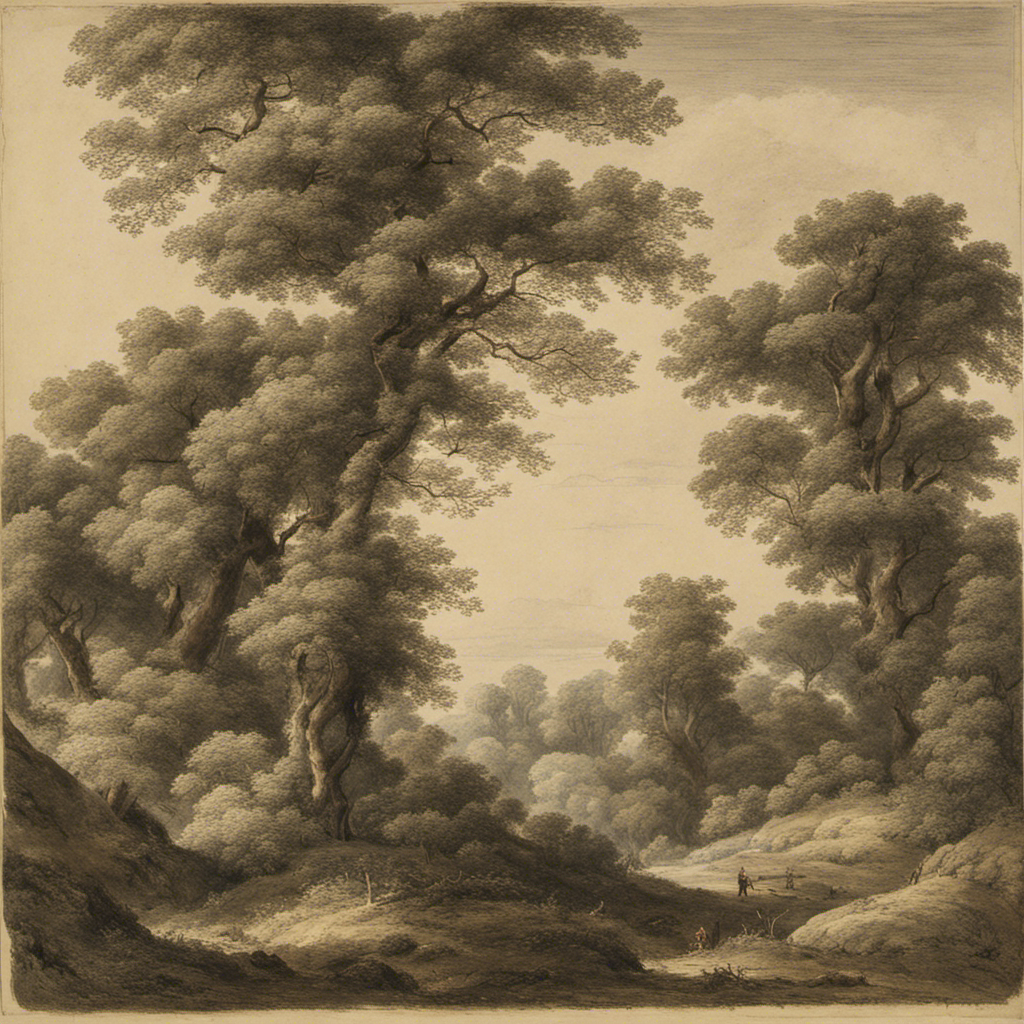

In [12]:
import base64
import io
from PIL import Image

base_64_img_str = response_body.get("artifacts")[0].get("base64")
image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image

## Generate streaming output

For large language models, it can take noticeable time to generate long output sequences. Rather than waiting for the entire response to be available, latency-sensitive applications may like to **stream** the response to users.

Run the code below to see how you can achieve this with Bedrock's `invoke_model_with_response_stream()` method - returning the response body in separate chunks.

In [13]:
from IPython.display import clear_output, display, display_markdown, Markdown
prompt_data = """Command: Write a blog about making strong business decisions as a leader.

Blog:
"""

body = json.dumps({"inputText": prompt_data})
modelId = "amazon.titan-tg1-large"  # (Change this, and the request body, to try different models)
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model_with_response_stream(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    stream = response.get('body')
    output = []

    if stream:
        for event in stream:
            chunk = event.get('chunk')
            if chunk:
                chunk_obj = json.loads(chunk.get('bytes').decode())
                text = chunk_obj['outputText']
                display_markdown(Markdown(print(text, end='')))

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


As a leader, making strong business decisions is crucial for the success of your organization. Here are some key strategies to help you make informed and effective decisions:

Define your goals and objectives: Before making any decision, it's important to clearly define what you want to achieve. This will help you stay focused and ensure that your decision aligns with your overall business strategy.

Gather relevant information: Collect and analyze relevant data and information about the issue at hand. This may include market trends, customer feedback, financial projections, and competitive analysis.

Consider multiple perspectives: Seek input and perspectives from your team, stakeholders, and

### Anthropic Claude (messages API)

In [14]:
# If you'd like to try your own prompt, edit this parameter!
prompt_data = """Human: Write me 500 word paragraph about making strong business decisions as a leader.

Assistant:
"""


In [15]:
messages_API_body = {
    "anthropic_version": "bedrock-2023-05-31", 
    "max_tokens": int(500/0.75),
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt_data
                }
            ]
        }
    ]
}

In [16]:
from IPython.display import clear_output, display, display_markdown, Markdown

body = json.dumps(messages_API_body)
modelId = "anthropic.claude-instant-v1"  # (Change this to try different model versions)
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model_with_response_stream(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    
    stream = response.get('body')
    
    
    output = []

    if stream:
        for event in stream:
            chunk = event.get('chunk')
            if chunk:
                chunk_obj = json.loads(chunk.get('bytes').decode())
                if 'delta' in chunk_obj:
                    delta_obj = chunk_obj.get('delta', None)
                    if delta_obj:
                        text = delta_obj.get('text', None)
                        print(text,end='')
                        if not text :
                            break
                    # output.append(text[0]) if type(text) is list and len(text)>0 else output.append('')
                    # display_markdown(Markdown(text))

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


Here is a 493 word paragraph on making strong business decisions as a leader:

As a leader, one of the most important responsibilities is making strong business decisions that will positively impact the company. With every decision comes opportunities as well as potential risks, so it is crucial to thoughtfully evaluate all options before deciding on a course of action. Effective decision making involves gathering insights from various sources, considering both short and long term consequences, and being willing to accept responsibility for the outcomes, whether positive or negative. Leaders who make rash or emotional decisions without properly examining alternatives often find themselves facing unforeseen problems down the road. It is far better to take the time needed to make an informed choice than to react hastily.  

When analyzing potential decisions, leaders should start by considering how each option aligns with the company's overarching goals and strategic plan. Understanding 

## Generate embeddings

Use text embeddings to convert text into meaningful vector representations. You input a body of text 
and the output is a (1 x n) vector. You can use embedding vectors for a wide variety of applications. 
Bedrock currently offers Titan Embeddings for text embedding that supports text similarity (finding the 
semantic similarity between bodies of text) and text retrieval (such as search).

At the time of writing you can use `amazon.titan-embed-text-v1` as embedding model via the API. The input text size is 8192 tokens and the output vector length is 1536.

To use a text embeddings model, use the InvokeModel API operation or the Python SDK.
Use InvokeModel to retrieve the vector representation of the input text from the specified model.



#### Input

```json
{
    "inputText": "<text>"
}
```

#### Output

```json
{
    "embedding": []
}
```


Let's see how to generate embeddings of some text:

In [17]:
prompt_data = "Amazon Bedrock supports foundation models from industry-leading providers such as \
AI21 Labs, Anthropic, Stability AI, and Amazon. Choose the model that is best suited to achieving \
your unique goals."


In [18]:
body = json.dumps({"inputText": prompt_data})
modelId = "amazon.titan-embed-g1-text-02"  # (Change this to try different embedding models)
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    embedding = response_body.get("embedding")
    print(f"The embedding vector has {len(embedding)} values\n{embedding[0:3]+['...']+embedding[-3:]}")

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


The embedding vector has 1536 values
[0.16601562, 0.23632812, 0.703125, '...', 0.26953125, -0.609375, -0.55078125]


## Next steps

In this notebook we showed some basic examples of invoking Amazon Bedrock models using the AWS Python SDK. You're now ready to explore the other labs to dive deeper on different use-cases and patterns.